Pinhole camera model.

Only one frame of reference, with origin in the middle of camera positions.

4 camera positions on a rectangular outlay.

Focus distance: f.

Pinholes in plane z = 0.

Image planes (sensors) in plane z = -f.

Assumed known: all pinhole and image positions in reference frame.

Goal: find position of object.

All distances in mm.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Data generation

In [2]:
# INPUT

# Pinhole positions
pinhole = np.array([
    [-40,  65, 0],
    [ 40,  65, 0],
    [-40, -65, 0],
    [ 40, -65, 0]
])

# Focus distance
f = 4

# What we would not know: object position
obj = np.array([20, 10, 300])
# obj = np.array([0, 0, 300])

In [3]:
# Number of cameras
n_cam = pinhole.shape[0]

In [4]:
# What we would measure: coordinates of projections on image planes (z = -f) 
# -(x_img-x_cam)/(z_img-z_cam) = (x_obj-x_cam)/(z_obj-z_cam)
# x_img = -(x_obj-x_cam)*(z_img-z_cam)/(z_obj-z_cam) + x_cam 

image = np.array([
    [(obj[0]-pinhole[p,0])*(-f-pinhole[p,2])/(obj[2]-pinhole[p,2]) + pinhole[p,0],
     (obj[1]-pinhole[p,1])*(-f-pinhole[p,2])/(obj[2]-pinhole[p,2]) + pinhole[p,1],
     -f]
    for p in range(n_cam)
])

image

array([[-40.8       ,  65.73333333,  -4.        ],
       [ 40.26666667,  65.73333333,  -4.        ],
       [-40.8       , -66.        ,  -4.        ],
       [ 40.26666667, -66.        ,  -4.        ]])

In [5]:
# Fake measuring errors
...

# Reconstruction (finding obj)

In [6]:
# Directions of rays through images and pinholes
direction = np.array([pinhole[i] - image[i] for i in range(n_cam)])
direction

array([[ 0.8       , -0.73333333,  4.        ],
       [-0.26666667, -0.73333333,  4.        ],
       [ 0.8       ,  1.        ,  4.        ],
       [-0.26666667,  1.        ,  4.        ]])

In [7]:
# Check: for each ray: does this contain the image and the object? (The pinhole for sure is on the ray.)
for i in range(n_cam):
    print([(image[i,a]-pinhole[i,a])/direction[i,a] for a in range(3)])
    print([(obj[a]-pinhole[i,a])/direction[i,a] for a in range(3)])



[-1.0, -1.0, -1.0]
[75.00000000000027, 74.9999999999999, 75.0]
[-1.0, -1.0, -1.0]
[75.00000000000027, 74.9999999999999, 75.0]
[-1.0, -1.0, -1.0]
[75.00000000000027, 75.0, 75.0]
[-1.0, -1.0, -1.0]
[75.00000000000027, 75.0, 75.0]


In [8]:
# Coefficient and constant matrices
# rows = n_cam*(n_cam-1)*3
# A = np.zeros((rows, n_cam))
# B = np.zeros((rows))

A = []
B = []
for i in range(n_cam):
    for j in range(i+1, n_cam):
        for a in range(3): # x,y,z
            row = [0]*n_cam
            row[i] =  direction[i,a]
            row[j] = -direction[j,a]
            A += [row]
            B += [-image[i,a] + image[j,a]]

A = np.array(A)
B = np.array(B)
# print(A)
# print(B)

In [9]:
# Least squares solution using pseudoinverse
np.dot(np.dot(np.linalg.inv(np.dot(A.transpose(), A)), A.transpose()), B)

array([76., 76., 76., 76.])

In [10]:
t_est, residuals, rank, singular_values = np.linalg.lstsq(A, B, rcond='warn')
t_est

/tmp/ipykernel_207564/2083618071.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  t_est, residuals, rank, singular_values = np.linalg.lstsq(A, B, rcond='warn')


array([76., 76., 76., 76.])

In [11]:
print(obj)
print()

# Reconstruction (can be done along all rays)
for i in range(n_cam):
    obj_est = image[i] + t_est[i]*direction[i]
    error = np.linalg.norm(obj_est - obj)
    print(error, obj_est)

[ 20  10 300]

2.4137545653194124e-13 [ 20.  10. 300.]
2.604892696897332e-13 [ 20.  10. 300.]
2.898457019905882e-13 [ 20.  10. 300.]
1.3349885981068564e-13 [ 20.  10. 300.]


# Visualisation

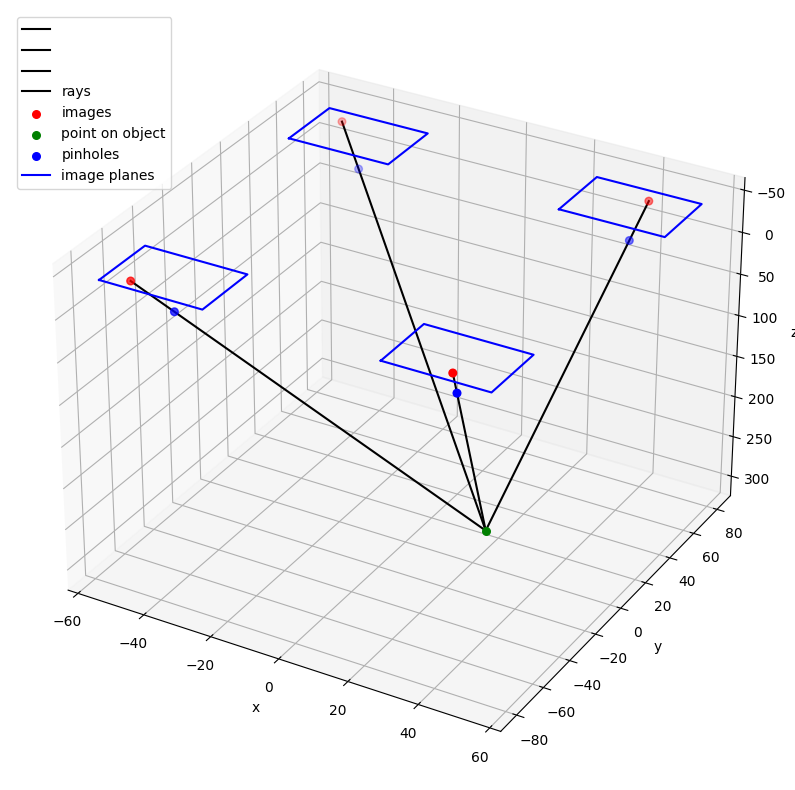

In [12]:
from mpl_toolkits.mplot3d import Axes3D

# Image coordinates for schematics (larger f)
f_sch = 40
image_sch = np.array([
    [(obj[0]-pinhole[p,0])*(-f_sch-pinhole[p,2])/(obj[2]-pinhole[p,2]) + pinhole[p,0],
     (obj[1]-pinhole[p,1])*(-f_sch-pinhole[p,2])/(obj[2]-pinhole[p,2]) + pinhole[p,1],
     -f_sch]
    for p in range(n_cam)
])

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")


# Draw projection rays
for c in range(n_cam):
    ax.plot3D([obj[0], image_sch[c,0]], [obj[1], image_sch[c,1]], [obj[2], image_sch[c,2]], color='black')

# Draw pinholes, images and object
ax.scatter(image_sch[:,0], image_sch[:,1], image_sch[:,2], s=30, color='red')
ax.scatter(obj[0], obj[1], obj[2], s=30, color='green')
ax.scatter(pinhole[:,0], pinhole[:,1], pinhole[:,2], s=30, color = 'blue')







# Draw image sensors
edge_sensor = 30
for c in range(n_cam):
    ctr = pinhole[c].copy()
    ctr[2] = -f_sch
    ax.plot3D(
        [ctr[0] - edge_sensor/2, ctr[0] - edge_sensor/2, ctr[0] + edge_sensor/2, ctr[0] + edge_sensor/2, ctr[0] - edge_sensor/2],
        [ctr[1] - edge_sensor/2, ctr[1] + edge_sensor/2, ctr[1] + edge_sensor/2, ctr[1] - edge_sensor/2, ctr[1] - edge_sensor/2],
        [-f_sch]*5,
        color = 'blue'
    )

    
plt.legend([None, None, None, 'rays', 'images', 'point on object', 
           'pinholes', 'image planes'])
    
# # Coordinate system axis
# origo=[0,0,0]
# ax.quiver(origo[0],origo[1],origo[2], 200, 0, 0, color="r",normalize=False)
# ax.quiver(origo[0],origo[1],origo[2], 0, 200, 0, color="g",normalize=False)
# ax.quiver(origo[0],origo[1],origo[2], 0, 0, 200, color="b",normalize=False)

# # axis label placement
# ax.text(0.1, 0.0, -0.2, r'$0$')
# ax.text(1.3, 0, 0, r'$x$')
# ax.text(0, 1.3, 0, r'$y$')
# ax.text(0, 0, 1.3, r'$z$')

# ax.axis('equal')


# Upside down
ax.invert_zaxis()

plt.show()

# EXP



In [13]:
# d = direction
# i = image

# A_alt = np.array([
#     [d[0,0], -d[1,0],       0,      0],
#     [d[0,1], -d[1,1],       0,      0],
#     [d[0,2], -d[1,2],       0,      0],

#     [d[0,0],       0, -d[2,0],      0],
#     [d[0,1],       0, -d[2,1],      0],
#     [d[0,2],       0, -d[2,2],      0],

#     [d[0,0],       0,       0, -d[3,0]],
#     [d[0,1],       0,       0, -d[3,1]],
#     [d[0,2],       0,       0, -d[3,2]],
    
#     [     0, d[1,0], -d[2,0],      0],
#     [     0, d[1,1], -d[2,1],      0],
#     [     0, d[1,2], -d[2,2],      0],

#     [     0, d[1,0],       0, -d[3,0]],
#     [     0, d[1,1],       0, -d[3,1]],
#     [     0, d[1,2],       0, -d[3,2]],
     
#     [     0,      0,  d[2,0], -d[3,0]],
#     [     0,      0,  d[2,1], -d[3,1]],
#     [     0,      0,  d[2,2], -d[3,2]],
# ])

# B_alt = np.array([
#     -i[0,0] + i[1,0],
#     -i[0,1] + i[1,1],
#     -i[0,2] + i[1,2],
    
#     -i[0,0] + i[2,0],
#     -i[0,1] + i[2,1],
#     -i[0,2] + i[2,2],
    
#     -i[0,0] + i[3,0],
#     -i[0,1] + i[3,1],
#     -i[0,2] + i[3,2],

    
#     -i[1,0] + i[2,0],
#     -i[1,1] + i[2,1],
#     -i[1,2] + i[2,2],
    
#     -i[1,0] + i[3,0],
#     -i[1,1] + i[3,1],
#     -i[1,2] + i[3,2],

    
#     -i[2,0] + i[3,0],
#     -i[2,1] + i[3,1],
#     -i[2,2] + i[3,2],
# ])

# # Must be True, True
# np.all(A_alt == A), np.all(B_alt == B)

In [14]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# import numpy as np

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')


# x = [1, 2, 1.2, 1.5, 1.5]
# y = [1, 1.2, 2, 1.5, 1.5]
# z = [.5, .5, .5, 1.2, 2]

# a = []
# b = []
# c = []
# for item in x:
#     a.append(float(item))
# for item in y:
#     b.append(float(item))
# for item in z:
#     c.append(float(item))

# r = np.array(a)
# s = np.array(b)
# t = np.array(c)

# ax.set_xlabel("x axis")
# ax.set_ylabel("y axis")
# ax.set_zlabel("z axis")


# ax.scatter(r,s,zs = t, s=200)
# ax.plot3D(r,s,z)
# plt.show()